In [1]:
import pandas as pd
import numpy as np
import os
from bokeh.io import output_notebook, show
output_notebook()
import bokeh as bh
from sklearn.preprocessing import LabelEncoder
import gc
from glob import glob
import matplotlib.pyplot as plt
import re
from math import ceil
import xgboost as xgb
from sklearn.model_selection import GroupKFold,KFold,StratifiedKFold,train_test_split,TimeSeriesSplit
import random
import operator
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import datetime 
import lightgbm as lgb
import fastai.tabular as ft
pd.options.display.max_columns = 1000
import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
train_id = pd.read_csv('train_identity.csv')
train_trans = pd.read_csv('train_transaction.csv')
train_df = train_trans.merge(train_id,how='left',on=['TransactionID'])

In [3]:
test_id = pd.read_csv('test_identity.csv')
test_trans = pd.read_csv('test_transaction.csv')
test_df = test_trans.merge(test_id,how='left',on=['TransactionID'])

In [26]:
train_df = train_trans
test_df = test_trans
# del train_id,train_trans,test_id,test_trans
# gc.collect()

In [27]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
          'scranton.edu': 'other', 'netzero.net': 'other',
          'optonline.net': 'other', 'comcast.net': 'other', 
          'cfl.rr.com': 'other', 'sc.rr.com': 'other',
          'suddenlink.net': 'other', 'windstream.net': 'other',
          'gmx.de': 'other', 'earthlink.net': 'other', 
          'servicios-ta.com': 'other', 'bellsouth.net': 'other', 
          'web.de': 'other', 'mail.com': 'other',
          'cableone.net': 'other', 'roadrunner.com': 'other', 
          'protonmail.com': 'other', 'anonymous.com': 'other',
          'juno.com': 'other', 'ptd.net': 'other',
          'netzero.com': 'other', 'cox.net': 'other', 
          'hotmail.co.uk': 'microsoft', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 
          'live.com': 'microsoft', 'aim.com': 'aol',
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 
          'hotmail.com': 'microsoft',  
          'hotmail.fr': 'microsoft',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 
          'yahoo.de': 'yahoo', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 
           'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
          'embarqmail.com': 'centurylink', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft',
           'aol.com': 'aol', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')


In [28]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x

def define_indexes(df):
    
    # create date column
    START_DATE = '2017-11-30'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT_n'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    df['year'] = df['TransactionDT_n'].dt.year
    df['month'] = df['TransactionDT_n'].dt.month
    df['dow'] = df['TransactionDT_n'].dt.dayofweek
    df['hour'] = df['TransactionDT_n'].dt.hour
    df['day'] = df['TransactionDT_n'].dt.day
   
    # create card ID 
    cards_cols= ['card1', 'card2', 'card3', 'card5']
    for card in cards_cols: 
        if '1' in card: 
            df['card_id']= df[card].map(str)
        else : 
            df['card_id']+= ' '+df[card].map(str)
    
    # small correction of the Card_ID
    df['Card_ID']=df['card_id'].apply(corret_card_id)

    return df

In [29]:
train_df = define_indexes(train_df)
test_df = define_indexes(test_df)

### v1 - fet

In [30]:
train_df['Trans_min_mean'] = train_df['TransactionAmt'] - train_df['TransactionAmt'].mean()
train_df['Trans_min_std'] = train_df['Trans_min_mean'] / train_df['TransactionAmt'].std()
test_df['Trans_min_mean'] = test_df['TransactionAmt'] - test_df['TransactionAmt'].mean()
test_df['Trans_min_std'] = test_df['Trans_min_mean'] / test_df['TransactionAmt'].std()

In [31]:
train_df['TransactionAmt_to_mean_card_id'] = train_df['TransactionAmt'] - train_df.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_card_id'] = train_df['TransactionAmt_to_mean_card_id'] / train_df.groupby(['Card_ID'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_mean_card_id'] = test_df['TransactionAmt'] - test_df.groupby(['Card_ID'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_card_id'] = test_df['TransactionAmt_to_mean_card_id'] / test_df.groupby(['Card_ID'])['TransactionAmt'].transform('std')

In [32]:
train_df['first_value_card1'] = train_df['card1'].astype(str).str[0:1].astype(float)
train_df['two_value_card1'] = train_df['card1'].astype(str).str[0:2].astype(float)

test_df['first_value_card1'] = test_df['card1'].astype(str).str[0:1].astype(float)
test_df['two_value_card1'] = test_df['card1'].astype(str).str[0:2].astype(float)

train_df['card2'] = train_df['card2'].fillna(0)
train_df['first_value_card2'] = train_df['card2'].astype(str).str[0:1].astype(float)
train_df['two_value_card2'] = train_df['card2'].astype(str).str[0:2].astype(float)

test_df['card2'] = test_df['card2'].fillna(0)
test_df['first_value_card2'] = test_df['card2'].astype(str).str[0:1].astype(float)
test_df['two_value_card2'] = test_df['card2'].astype(str).str[0:2].astype(float)

### V2 - Fet

In [33]:
train_df['TransactionAmt_decimal'] = ((train_df['TransactionAmt'] - train_df['TransactionAmt'].astype(int)) * 1000).astype(int)
test_df['TransactionAmt_decimal'] = ((test_df['TransactionAmt'] - test_df['TransactionAmt'].astype(int)) * 1000).astype(int)


def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    return train_df, test_df

i_cols = ['card1','card2','addr1'] 
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)
# Count encoding for card1 feature. 
# Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
# train_df['card1_count_full'] = train_df['card1'].map(pd.concat([train_df['card1'], test_df['card1']], ignore_index=True).value_counts(dropna=False))
# test_df['card1_count_full'] = test_df['card1'].map(pd.concat([train_df['card1'], test_df['card1']], ignore_index=True).value_counts(dropna=False))

# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
# train_df['Transaction_day_of_week'] = np.floor((train_df['TransactionDT'] / (3600 * 24) - 1) % 7)
# test_df['Transaction_day_of_week'] = np.floor((test_df['TransactionDT'] / (3600 * 24) - 1) % 7)
# train_df['Transaction_hour'] = np.floor(train_df['TransactionDT'] / 3600) % 24
# test_df['Transaction_hour'] = np.floor(test_df['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
# for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
#                 'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

#     f1, f2 = feature.split('__')
#     train_df[feature] = train_df[f1].astype(str) + '_' + train_df[f2].astype(str)
#     test_df[feature] = test_df[f1].astype(str) + '_' + test_df[f2].astype(str)

#     le = LabelEncoder()
#     le.fit(list(train_df[feature].astype(str).values) + list(test_df[feature].astype(str).values))
#     train_df[feature] = le.transform(list(train_df[feature].astype(str).values))
#     test_df[feature] = le.transform(list(test_df[feature].astype(str).values))
    
# for feature in ['id_34', 'id_36']:
#     if feature in cols:
#         # Count encoded for both train and test
#         train_df[feature + '_count_full'] = train_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))
#         test_df[feature + '_count_full'] = test_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))
        
# for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
#     if feature in cols:
#         # Count encoded separately for train and test
#         train_df[feature + '_count_dist'] = train_df[feature].map(train_df[feature].value_counts(dropna=False))
#         test_df[feature + '_count_dist'] = test_df[feature].map(test_df[feature].value_counts(dropna=False))


In [34]:
cont_cols = ['card1','addr1','addr2']
cont_combs = ['card1','card2','card3','card4','card6']
agg_cols = ['TransactionAmt']

In [35]:
def cont_aggs(train_df, test_df, cont_cols,agg_cols):
    temp_df = pd.concat([train_df[set(cont_cols + agg_cols + cont_combs)], test_df[set(cont_cols + agg_cols + cont_combs)]])
    rm_cols = []
    for i in cont_cols:   
        for j in cont_combs:
            if i != j:
                x= [i,j]
                print(x)
                y = '_'.join(x)
                for col in agg_cols:
                    temp_agg = temp_df.groupby(x).agg({
                                                    col: [("mean_"+str(col)+"_"+y, "mean"),
                                                       ("sd_"+str(col)+"_"+y, lambda x: np.std(x))]      
                                                  })


                    temp_agg.columns = temp_agg.columns.droplevel()
                    temp_agg = temp_agg.reset_index(drop=False)
                    train_df = train_df.merge(temp_agg, on=x, how="left")
                    test_df = test_df.merge(temp_agg, on=x, how="left")
                    mn_delta = str(col)+"_"+y+"_delta_mean"
                    sd_delta = str(col)+"_"+y+"_delta_sd"
                    mn = "mean_"+str(col)+"_"+y
                    sd = "sd_"+str(col)+"_"+y
                    rm_cols.extend([mn,sd])
                    train_df[mn_delta] = train_df[mn] - train_df[str(col)]
                    train_df[sd_delta] = (train_df[mn] - train_df[str(col)])/train_df[sd]
                    test_df[mn_delta] = test_df[mn] - test_df[str(col)]
                    test_df[sd_delta] = (test_df[mn] - test_df[str(col)])/test_df[sd]
        
    return train_df,test_df,rm_cols
train_df,test_df,rm_cols = cont_aggs(train_df, test_df, cont_cols,agg_cols)

['card1', 'card2']
['card1', 'card3']
['card1', 'card4']
['card1', 'card6']
['addr1', 'card1']
['addr1', 'card2']
['addr1', 'card3']
['addr1', 'card4']
['addr1', 'card6']
['addr2', 'card1']
['addr2', 'card2']
['addr2', 'card3']
['addr2', 'card4']
['addr2', 'card6']


In [36]:
cols = list(train_df.columns)
for i in ['isFraud','TransactionDT_n','TransactionDT']:
    cols.remove(i)

In [37]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [38]:
train_mv = missing_data(train_df)
test_mv = missing_data(test_df)

In [39]:
col_exp_lst = []
for i in cols:
    if (train_mv[i]['Percent'] > 70 and test_mv[i]['Percent'] > 70) or train_mv[i]['Percent'] > 80:
        col_exp_lst.append(i)

In [40]:
cols_for_model = list(train_df.columns)
col_exp_lst.extend(['isFraud','TransactionDT_n','TransactionDT','TransactionID','card_id'])
for i in col_exp_lst:
    print(i)
    cols_for_model.remove(i)

dist2
R_emaildomain
D6
D7
D8
D9
D12
D13
D14
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167
V168
V169
V170
V171
V172
V173
V174
V175
V176
V177
V178
V179
V180
V181
V182
V183
V184
V185
V186
V187
V188
V189
V190
V191
V192
V193
V194
V195
V196
V197
V198
V199
V200
V201
V202
V203
V204
V205
V206
V207
V208
V209
V210
V211
V212
V213
V214
V215
V216
V217
V218
V219
V220
V221
V222
V223
V224
V225
V226
V227
V228
V229
V230
V231
V232
V233
V234
V235
V236
V237
V238
V239
V240
V241
V242
V243
V244
V245
V246
V247
V248
V249
V250
V251
V252
V253
V254
V255
V256
V257
V258
V259
V260
V261
V262
V263
V264
V265
V266
V267
V268
V269
V270
V271
V272
V273
V274
V275
V276
V277
V278
V322
V323
V324
V325
V326
V327
V328
V329
V330
V331
V332
V333
V334
V335
V336
V337
V338
V339
R_emaildomain_bin
isFraud
TransactionDT_n
TransactionDT
TransactionID
card_id


In [41]:
for f in cols_for_model:
    if train_df[f].dtype=='object':
        print(f+"-"+str(train_df[f].dtype))
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

ProductCD-object
card4-object
card6-object
P_emaildomain-object
M1-object
M2-object
M3-object
M4-object
M5-object
M6-object
M7-object
M8-object
M9-object
P_emaildomain_bin-object
P_emaildomain_suffix-object
R_emaildomain_suffix-object
Card_ID-object


In [42]:
class MetricsMeter():    
    def __init__(self, y_true, y_pred, threshold):
        self.y_true = y_true        
        self.y_pred = y_pred        
        self.thresh = threshold            
    
    def fit(self):        
        metrics = {}        
        metrics['auc'] = roc_auc_score(self.y_true, self.y_pred)                
        self.y_pred = [1 if x > self.thresh else 0 for x in self.y_pred]        
        metrics['f1'] = f1_score(self.y_true, self.y_pred,average = 'macro')        
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()                
        metrics['sensitivity/recall'] = tp / (tp+fn)
        metrics['precision'] = tp / (tp+fp)
        metrics["accuracy"] = (tp + tn) / (tp + fp + fn + tn)
        metrics['specificity'] = tn / (tn+fp)
        return metrics

In [43]:
def RunLGB(x_build,x_val,y_build,y_val,x_test,seed, dep=8, data_leaf=511, hessian_leaf=50):
    dbuild = xgb.DMatrix(x_build,y_build)
    dval = xgb.DMatrix(x_val,y_val)
    watchlist = [(dbuild, 'train'), (dval, 'val')]
#     params = {}
    
    params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    #'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1, # sqrt cols, log(cols)
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7, 
                    'nthreads':64,
                    'n_estimators':20000,
                    'max_bin':255, #remove
                    'verbose':-1,
                    'seed': seed,
                    'early_stopping_rounds':100, 
                } 
    
#     params["objective"] = "binary"
#     params['metric'] = 'auc'
# #     params["max_depth"] = dep
#     params["num_leaves"] = 63
#     params["min_data_in_leaf"] = data_leaf
#     params["min_sum_hessian_in_leaf"] = hessian_leaf
#     params["learning_rate"] = 0.01
#     params["bagging_fraction"] = 0.913
#     params["feature_fraction"] = 0.2
#     params["feature_fraction_seed"] = seed
#     params["bagging_freq"] = 8
#     params["bagging_seed"] = seed
#     params["nthread"] = 96
#     params["lambda_l2"] = 0.95
#     params["lambda_l1"] = 0.95
#     params["verbosity"] = -1
#     
    num_rounds = 20000
    plst = list(params.items())
    lgbuild = lgb.Dataset(x_build, label=y_build)
    lgval = lgb.Dataset(x_val, label=y_val)
    model = lgb.train(params, lgbuild, num_rounds, valid_sets=[lgbuild,lgval], verbose_eval=200)
    pred_val = model.predict(x_val, num_iteration=model.best_iteration)
    pred_t = model.predict(x_test, num_iteration=model.best_iteration)

    return(model,pred_val,pred_t)

In [44]:
train = train_df.reset_index(drop =True)
x_train = train[cols_for_model].fillna(-1)
y_train = train['isFraud']
dtest = xgb.DMatrix(test_df[cols_for_model].iloc[:])
td = test_df['TransactionID'].reset_index(drop=True)
x_test = test_df[cols_for_model].fillna(-1)

In [45]:
# del train_df,test_df
# gc.collect()


In [46]:
n_splits = 6
folds = GroupKFold(n_splits=n_splits)
x_groups = x_train["month"].values
auc_list = []
pred_test_f = 0
pred_train = np.zeros(train.shape[0])
for fold_nm,(build_index, val_index) in enumerate(folds.split(x_train, x_train, groups=x_groups)):
    print('fold number:', fold_nm)
    x_build = x_train.iloc[build_index]
    y_build = y_train.iloc[build_index]
    x_val = x_train.iloc[val_index]
    y_val = y_train.iloc[val_index]
    
    pred_val = 0
    pred_test = 0
    n_models = 0.
    
    model,pred_v,pred_t = RunLGB(x_build,x_val,y_build,y_val,x_test,seed = 10999973) 
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
#     model,pred_v,pred_t = RunLGB(x_build,x_val,y_build,y_val,x_test,seed = 99)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1

    
#     model,pred_v,pred_t = RunLGB(x_build,x_val,y_build,y_val,x_test,seed = 90351)
#     pred_val += pred_v
#     pred_test += pred_t
#     n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    auc = roc_auc_score(y_val, pred_val)
    auc_list.append(auc)

    
    pred_train[val_index] = pred_val
    print(min(pred_train)),print(max(pred_train))
    pred_test_f += pred_test / n_splits
    print(min(pred_test_f)),print(max(pred_test_f))
    
    #xgb_preds_lst.append(clf_xgb.predict(dtest))  
    #models.append(clf_xgb)
print(np.mean(auc_list))

fold number: 0
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.964123	valid_1's auc: 0.89263
[400]	training's auc: 0.988045	valid_1's auc: 0.90478
[600]	training's auc: 0.995225	valid_1's auc: 0.909555
[800]	training's auc: 0.997756	valid_1's auc: 0.911598
Early stopping, best iteration is:
[886]	training's auc: 0.998362	valid_1's auc: 0.912047
0.0
0.9933450580584766
3.5652856201981374e-05
0.16611082799792418
fold number: 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.963309	valid_1's auc: 0.917504
[400]	training's auc: 0.987579	valid_1's auc: 0.932394
[600]	training's auc: 0.995198	valid_1's auc: 0.937758
[800]	training's auc: 0.997851	valid_1's auc: 0.939878
Early stopping, best iteration is:
[899]	training's auc: 0.998487	valid_1's auc: 0.94029
0.0
0.9957344858382511
8.851422602370047e-05
0.33212965949537054
fold number: 2
Training until validation scores don't improve for 100 rounds.
[200]	training's a

In [47]:
print(roc_auc_score(y_train, pred_train)) # 0.932608547214282

0.9370077084138282


In [48]:
pred_df = pd.DataFrame(pred_test_f ,columns = ['isFraud'])

In [49]:
fnl = pd.concat([td, pred_df], axis=1)

In [50]:
predv1_data = pd.concat([train['TransactionID'],pd.DataFrame(pred_train ,columns = ['v1pred'])])

In [51]:
fnl.to_csv("lgb_v3_3_n_revamp_preds.csv",index=False)


In [52]:
len(cols_for_model)

302

In [53]:
predv1_data.to_csv("predv1_data_ensb1.csv",index=False)

In [27]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),cols_for_model)), columns=['Value','Feature'])

In [28]:
feature_imp_lst = feature_imp[feature_imp['Value'] >= 100]['Feature'].values

In [29]:
len(feature_imp_lst)

253

In [30]:
feature_imp

,Value,Feature
0,0,V107
1,0,V27
2,0,V28
3,0,V305
4,0,V68
5,2,V89
6,3,V117
7,3,V120
8,5,V122
9,7,V119


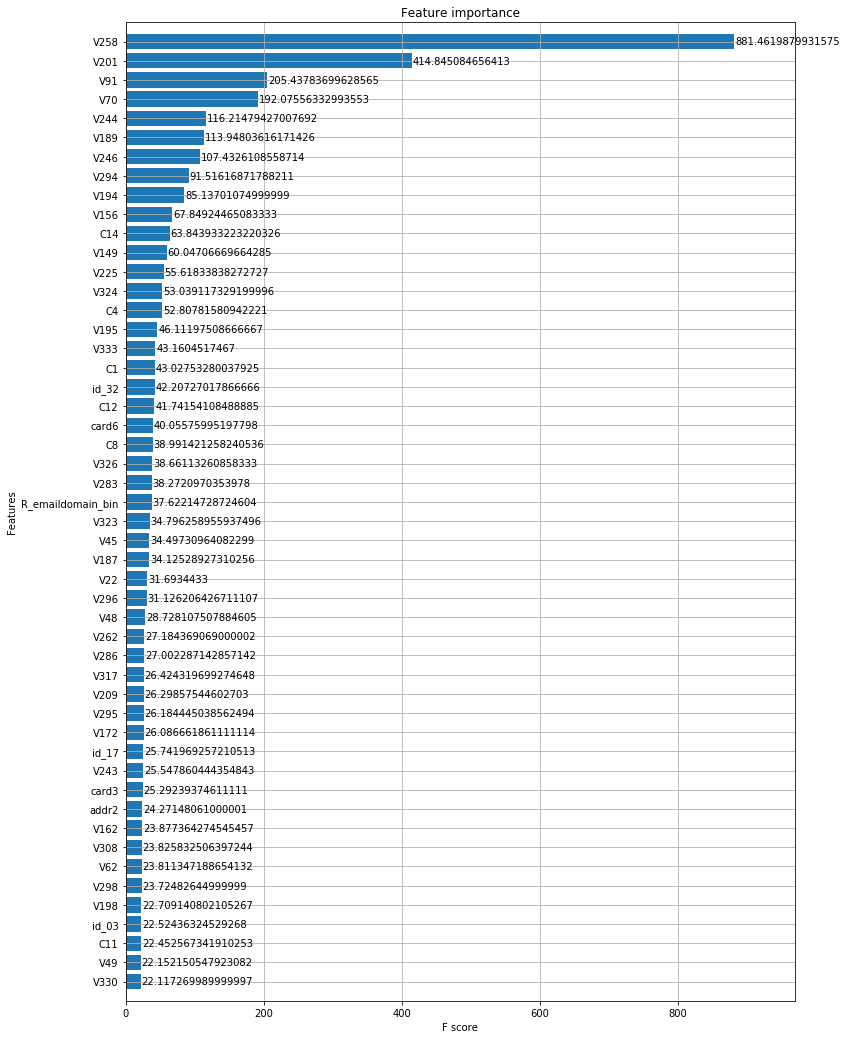

In [39]:
fig, ax = plt.subplots(figsize=(12,18))

xgb.plot_importance(model,importance_type= "gain", max_num_features=50, height=0.8, ax=ax)
plt.show()